In [1]:
import warnings
warnings.filterwarnings('ignore')

import astropy
import astropy.constants as ac
import astropy.units as au
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import random 
import glob 
import aplpy
import sys
sys.path.append('/Users/ashleybarnes/github/data_cube_analysis/')

import getdata
import moments
import rms
import masks
import histograms
from astropy.table import Table

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

In [41]:
### For getting moment maps
def get_moms(cube, outputfile=None,
             momvelo=None, rmsvelo=None,
             hthresh=5, lthresh=2):

    if (rmsvelo==None).any(): 
        print('running auto rms mask')
        rms_map = rms.get_rmsrob(cube)
    else: 
        rms_map = rms.get_rms(cube, rmsvelo)
    
    mask = masks.get_expmask(cube, rms_map, 
                             hthresh=hthresh, lthresh=lthresh, 
                             beamarea=1, randomnoise=False)
    
    cube_masked = cube.with_mask(mask)
    if (momvelo==None).any(): 
        momvelo = [cube.spectral_extrema[0].value, cube.spectral_extrema[1].value]
        moms = moments.get_momentmaps(cube_masked, rms_map, momvelo)
    else: 
        moms = moments.get_momentmaps(cube_masked, rms_map, momvelo)
   
    if outputfile!=None:
        moms['mom0'].writeto('%s_mom.fits' %outputfile, overwrite=True)
        moms['max'].writeto('%s_max.fits' %outputfile, overwrite=True)
        moms['mom0s2n'].writeto('%s_mom0s2n.fits' %outputfile, overwrite=True)
    
    return(cube, moms, rms_map)

### For updating rest frequency
def get_rest_freqs(rest_freq, source_velo=0*au.km/au.s):
    """Return the rest frequency adjusted for the source systemic velocity 
    i.e. the line should be centred on 0kms"""
    rest_freqs_sys = rest_freq - ((source_velo / ac.c) * rest_freq).to('GHz')
    return rest_freqs_sys

In [31]:
### For plotting
def get_scaling(data):
    data = (data-np.nanmin(data))/(np.nanmax(data)-np.nanmin(data))
    return(data)

In [32]:
"""Get source infomation"""

galaxy = 'ngc4321'

sampletable = Table.read('./../../../../../Projects/pressures/phangs/data/sample_table/phangs_sample_table_v1p6.fits')
mask = sampletable['name']==galaxy
vlsr = sampletable['orient_vlsr'][mask].quantity[0]
print('[INFO] vlsr = %f km/s' %vlsr.value)

[INFO] vlsr = 1572.312500 km/s


In [33]:
"""Make shifted cubes - to HCN frequency, and centre on 0kms"""

inputfile = './../data/cubes/ngc4321_12m+7m+tp_hcn_pbcorr_trimmed_k.fits' 
outputfile = inputfile.replace('cubes', 'moms')
print('[INFO] infile = %s' %inputfile)
print('[INFO] outputfile = %s' %outputfile)

rest_freq = 88.6318473 #HCN 
rest_freq_sys = get_rest_freqs(rest_freq*au.GHz, vlsr)

hdu = fits.open(inputfile)[0]
cube = getdata.get_cube(hdu)
cube = cube.with_spectral_unit(unit=au.km/au.s,
                                velocity_convention='radio', 
                                rest_value=rest_freq_sys)

cube = cube.spectral_slab(-500*au.km/au.s, 500*au.km/au.s)

[INFO] infile = ./../data/cubes/ngc4321_12m+7m+tp_hcn_pbcorr_trimmed_k.fits
[INFO] outputfile = ./../data/moms/ngc4321_12m+7m+tp_hcn_pbcorr_trimmed_k.fits


In [43]:
"""Make moment maps"""

# Uncomment if you want fully auto
# _, moms, rms_map = get_moms(cube, outputfile=outputfile.replace('.fits', ''), hthresh=3, lthresh=1.5)

# Uncomment if you have parameters for rms velocity and moment velocities 
_, moms, rms_map = get_moms(cube, outputfile=outputfile.replace('.fits', ''), hthresh=3, lthresh=1.5, 
                           momvelo=np.array([-250,250]), rmsvelo=np.array([[-500,-250],[250,500]]))

rms = 0.007249 K


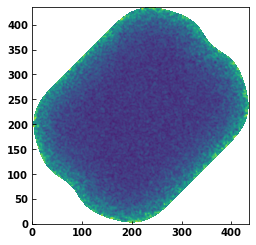

In [44]:
# Check RMS maps

plt.imshow(rms_map.data, origin='lower')
rms_mean = np.nanmedian(rms_map.data)
print('rms = %f K' %rms_mean)

In [45]:
hdumom0 = moms['mom0']
hdumax = moms['max']
hdus2n = moms['mom0s2n']

hdumom0.data = get_scaling(hdumom0.data)
hdumom0.data = np.log10(hdumom0.data)

hdumax.data = get_scaling(hdumax.data)
hdumax.data = np.log10(hdumax.data)

mask = np.isnan(hdumom0.data)*1
hdu_mask = fits.PrimaryHDU(mask, hdumax.header)

INFO: Auto-setting vmin to -2.556e+00 [aplpy.core]
INFO: Auto-setting vmax to -3.627e-02 [aplpy.core]
INFO: Auto-setting vmin to -1.386e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.882e-02 [aplpy.core]


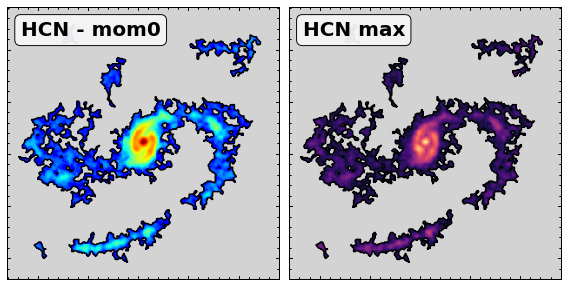

In [46]:
fig = plt.figure(figsize=(10, 5)) 
fig.tight_layout()
fig.subplots_adjust(wspace=0.02)


ax1 = aplpy.FITSFigure(hdumom0, subplot=(1,2,1), figure=fig) 
ax1.show_colorscale(pmin=5, pmax=100, stretch='linear', cmap='jet')
ax1.show_contour(hdu_mask, levels=[1], colors='black')

# hdu_s2n.data[np.isnan(hdu_s2n.data)] = 0 
# ax.show_contour(hdu_s2n, levels=[15,30,60,120], cmap='jet', linewidths=0.5, linestyles='-', alpha=1, smooth=1)

#     ax.show_contour(hdu_s2n, levels=[15,30,60,120], colors='C1', linewidths=0.5, linestyles='-', alpha=1, smooth=1)
# ax.show_contour(hdu_s2n, levels=[3], colors='black', linewidths=0.75, linestyles='-', alpha=1, smooth=1)

bbox = dict(facecolor='whitesmoke', alpha=0.95, boxstyle='round')
ax1.add_label(0.05, 0.95, r'HCN - mom0', 
    ha='left', va='top',
    fontsize=20,
    bbox = bbox,
    relative=True,
    weight='bold')

ax1.set_nan_color('lightgrey')

ax1.ticks.set_color('black')
ax1.tick_labels.set_xformat('dd.dd')
ax1.tick_labels.set_yformat('dd.dd')

ax1.tick_labels.hide()
ax1.axis_labels.hide()

ax2 = aplpy.FITSFigure(hdumax, subplot=(1,2,2), figure=fig) 
ax2.show_colorscale(pmin=10, pmax=100, stretch='linear', cmap='magma')
ax2.show_contour(hdu_mask, levels=[1], colors='black')
# hdu_s2n.data[np.isnan(hdu_s2n.data)] = 0 
# ax.show_contour(hdu_s2n, levels=[15,30,60,120], cmap='jet', linewidths=0.5, linestyles='-', alpha=1, smooth=1)

#     ax.show_contour(hdu_s2n, levels=[15,30,60,120], colors='C1', linewidths=0.5, linestyles='-', alpha=1, smooth=1)
# ax.show_contour(hdu_s2n, levels=[3], colors='black', linewidths=0.75, linestyles='-', alpha=1, smooth=1)

ax2.add_label(0.05, 0.95, r'HCN max', 
    ha='left', va='top',
    fontsize=20,
    bbox = bbox,
    relative=True)

ax2.set_nan_color('lightgrey')

ax2.ticks.set_color('black')
ax2.tick_labels.set_xformat('dd.dd')
ax2.tick_labels.set_yformat('dd.dd')

ax2.tick_labels.hide()
ax2.axis_labels.hide()

ax1.recenter(185.7290263, 15.8221111, 0.0312569/1.2)
ax2.recenter(185.7290263, 15.8221111, 0.0312569/1.2)

# fig.savefig('../data/moms/ngc4321.pdf', bbox_inches='tight', dpi=300)  
# fig.savefig('../data/moms/ngc4321.png', bbox_inches='tight', dpi=300)  